In [156]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [157]:
%matplotlib inline
#######
# Importamos todas las dependencias
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

np.random.seed(12)

In [158]:
import pickle
import pandas as pd
with open('attrition_available_32.pkl', 'rb') as f:
    datos_empleados = pickle.load(f)

In [159]:
if not isinstance(datos_empleados, pd.DataFrame):
    datos_empleados = pd.DataFrame(datos_empleados)

In [160]:
# Separar las características y la variable objetivo
X = datos_empleados.drop('Attrition', axis=1)
y = datos_empleados['Attrition']

Division de los datos

In [161]:
# Seleccionados train/test en modo stratify, ya que el dataset se encuentra desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

Tratamiento de valores nulos

In [162]:
X_train.isnull().any()
X_train.isnull().sum()

hrs                        697
absences                   592
JobInvolvement             593
PerformanceRating          591
EnvironmentSatisfaction    657
JobSatisfaction             16
WorkLifeBalance            703
Age                        622
BusinessTravel             563
Department                 722
DistanceFromHome             0
Education                  713
EducationField             649
EmployeeCount              603
EmployeeID                 758
Gender                     729
JobLevel                   692
JobRole                    758
MaritalStatus              573
MonthlyIncome              603
NumCompaniesWorked         781
Over18                       0
PercentSalaryHike            0
StandardHours              693
StockOptionLevel           594
TotalWorkingYears          771
TrainingTimesLastYear      579
YearsAtCompany             604
YearsSinceLastPromotion    741
YearsWithCurrManager       593
dtype: int64

Vamos a dibujar los valores que son nulos

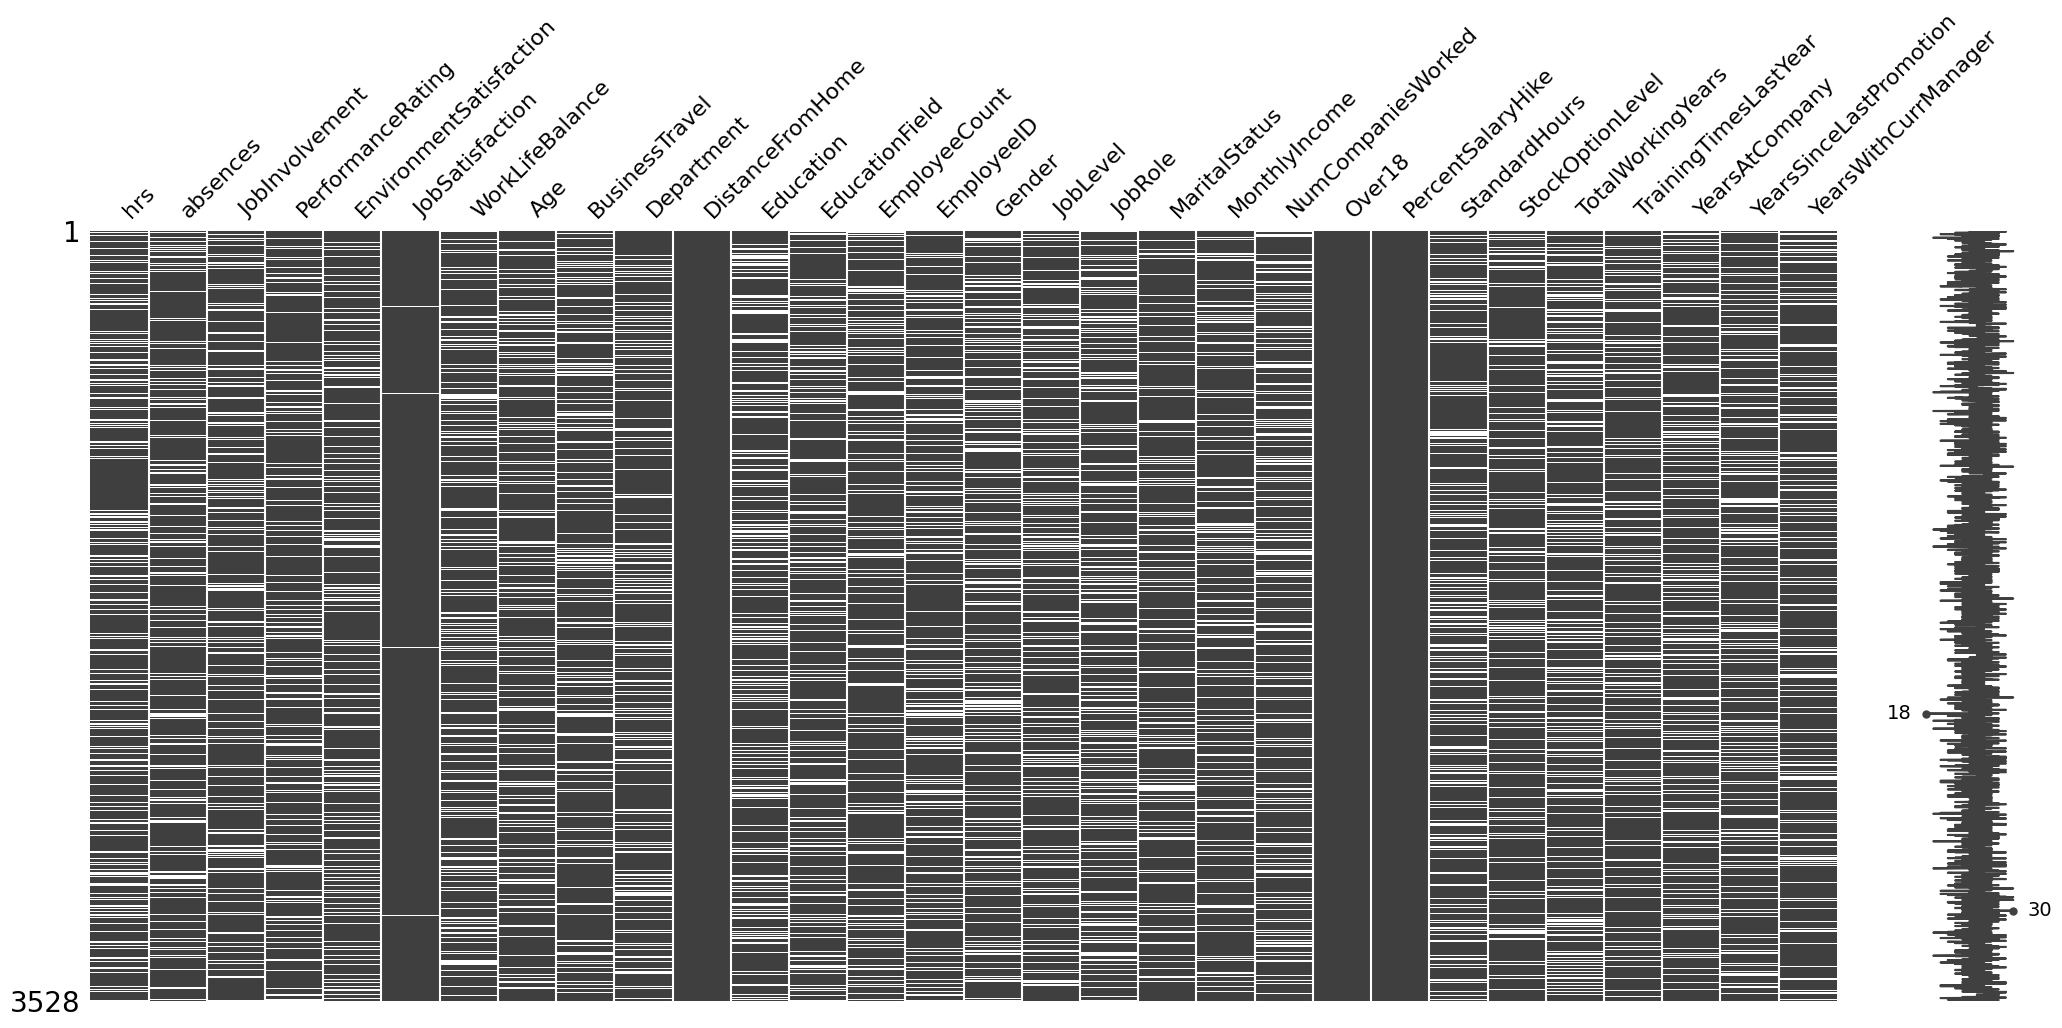

In [163]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X_train)
plt.show()

Vamos a calcular las correlaciones de los valores numéricos

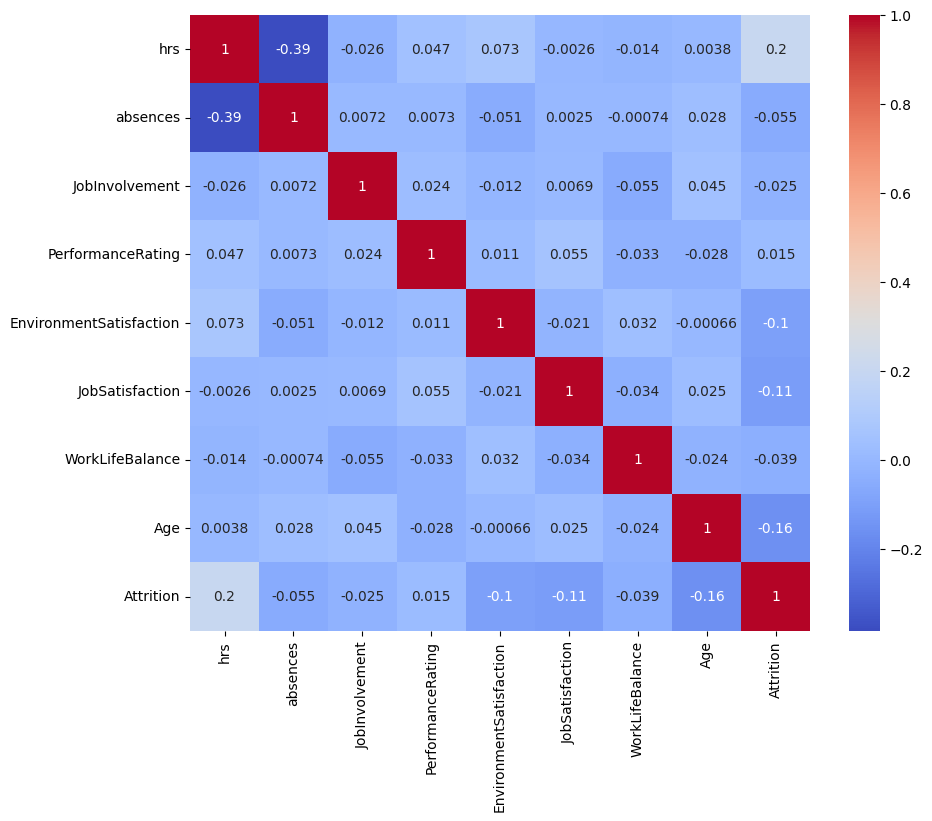

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que ya tienes X_train e y_train
# Convertir y_train a representación numérica (0 y 1)
y_train_numerico = y_train.map({'No': 0, 'Yes': 1})

# Concatenar X_train y y_train_numerico
X_comb = pd.concat([X_train, y_train_numerico], axis=1)

# Visualizar la correlación entre las características
plt.figure(figsize=(10, 8))
g = sns.heatmap(X_comb[['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'Attrition']].corr(),
                annot=True,
                cmap="coolwarm")
plt.show()


## Codificamos la salida


In [165]:
# Es necesario 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)

y_test = le.transform(y_test)
y_train = le.transform (y_train)

## Analizar tipos de variables




In [114]:
X_train.dtypes

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64
YearsAtCompany             float64
YearsSinceLastPromot

In [115]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

In [116]:
cat_cols

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object')

###EDA

Dimensiones del conjunto de datos: Determina el número de instancias (filas) y atributos (columnas).

In [117]:
print("Número de instancias:", X_train.shape[0])
print("Número de atributos:", X_train.shape[1])

Número de instancias: 3528
Número de atributos: 30


Tipo de atributos: Identifica los tipos de atributos (numéricos, ordinales y categóricos).

In [118]:
print("Atributos numéricos:", list(num_cols))
print("Atributos categóricos:", list(cat_cols))

Atributos numéricos: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Atributos categóricos: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']


Columnas constantes o innecesarias: Identifica las columnas con valores constantes o que no aportan información relevante.

In [119]:
constant_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
print("Columnas constantes:", constant_columns)

Columnas constantes: ['EmployeeCount', 'Over18', 'StandardHours']


Proporción de missing values por atributo: Calcula la proporción de valores faltantes por atributo.

In [120]:
missing_values = X_train.isna().mean().round(4) * 100
print("Porcentaje de valores faltantes por atributo:\n", missing_values)

Porcentaje de valores faltantes por atributo:
 hrs                        19.76
absences                   16.78
JobInvolvement             16.81
PerformanceRating          16.75
EnvironmentSatisfaction    18.62
JobSatisfaction             0.45
WorkLifeBalance            19.93
Age                        17.63
BusinessTravel             15.96
Department                 20.46
DistanceFromHome            0.00
Education                  20.21
EducationField             18.40
EmployeeCount              17.09
EmployeeID                 21.49
Gender                     20.66
JobLevel                   19.61
JobRole                    21.49
MaritalStatus              16.24
MonthlyIncome              17.09
NumCompaniesWorked         22.14
Over18                      0.00
PercentSalaryHike           0.00
StandardHours              19.64
StockOptionLevel           16.84
TotalWorkingYears          21.85
TrainingTimesLastYear      16.41
YearsAtCompany             17.12
YearsSinceLastPromotion    21

Tipo de problema: Determina si el problema es de clasificación o regresión. Esto dependerá de la variable objetivo y_train. Si es una variable categórica o binaria, se trata de un problema de clasificación; si es numérica, se trata de un problema de regresión.

Para las variables categóticas vamos a crear un pipeline donde:
1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer características más discriminantes

In [121]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

Ahora nos metemos con las variables numéricas. En este caso vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado

In [122]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

En el siguiente código vamos a utilizar la función `ColumnTransformer` para indicar cómo vamos a preprocesar a las variables categóricas y numéricas

In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])
       

## Creamos el clasificador
Por último, vamos a crear un `Pipeline` para unir el paso del preproceso, con el paso de entrenamiento del modelo. Fijaros que en el entrenamiento del modelo estoy indicando `class_weight='balanced'`, ya que el dataset se encuentra desbalanceado.

### LogisticRegression

In [124]:
from sklearn.linear_model import LogisticRegression

# Clasificador base: LogisticRegression con balance de clases
logreg_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=12, class_weight='balanced'))
])

# Calcula la puntuación de validación cruzada para el clasificador base
logreg_score = cross_val_score(logreg_clf, X_train, y_train, cv=5, scoring="accuracy").mean()
print("Accuracy score (LogisticRegression):", logreg_score)

Accuracy score (LogisticRegression): 0.6870709018946014


In [125]:
logreg_clf.fit(X_train, y_train)
y_pred_logreg = logreg_clf.predict(X_test)
print(f"El valor de balanced accuracy para regresión logística: {balanced_accuracy_score(y_test, y_pred_logreg)}")

El valor de balanced accuracy para regresión logística: 0.6708507803578226


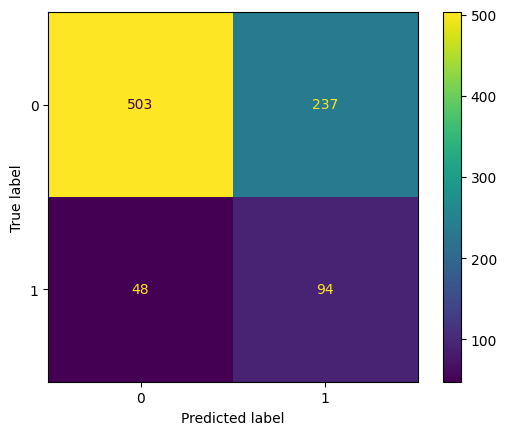

In [126]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=logreg_clf.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logreg_clf.classes_)
disp_logreg.plot()
plt.show()

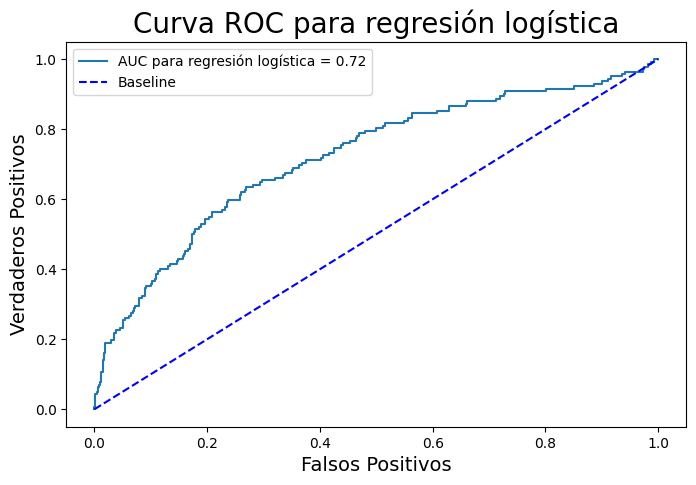

In [127]:
probs_logreg = logreg_clf.predict_proba(X_test)[:, 1]

auc_logreg = metrics.roc_auc_score(y_test, probs_logreg)
fpr_logreg, tpr_logreg, thresholds_logreg = metrics.roc_curve(y_test, probs_logreg)

plt.figure(figsize=(8, 5))
plt.plot(fpr_logreg, tpr_logreg, label=f'AUC para regresión logística = {auc_logreg:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC para regresión logística', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()
plt.show()

La precisión balanceada se usa en problemas de clasificación binaria y multiclase para tratar conjuntos de datos desbalanceados. Se define como la media del recall obtenido en cada clase.

### Usando XGBoost

In [128]:
import xgboost as xgb

# Suprime las advertencias relacionadas con use_label_encoder
warnings.filterwarnings("ignore", category=UserWarning, message="`use_label_encoder` is deprecated in 1.7.0.")

# Calcular scale_pos_weight
n_positives = sum(y_train == 1)
n_negatives = sum(y_train == 0)
scale_pos_weight = n_negatives / n_positives

# Clasificador avanzado: XGBClassifier
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=12, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
])

# Parámetros de distribución para XGBClassifier
xgb_param_dist = {
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__max_depth': list(range(2, 20)),
    'classifier__n_estimators': list(range(50, 500)),
    'classifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2],
    'classifier__reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2],
    'classifier__reg_lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2],
    'classifier__min_child_weight': list(range(1, 10))
}

# RandomizedSearchCV para ajustar hiperparámetros
xgb_random_search = RandomizedSearchCV(
    xgb_clf, param_distributions=xgb_param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=12
)

# Ajusta el modelo a los datos de entrenamiento
xgb_random_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros (XGBClassifier):", xgb_random_search.best_params_)

# Usa el mejor modelo encontrado para calcular la puntuación de validación cruzada
xgb_best_model = xgb_random_search.best_estimator_
xgb_score = cross_val_score(xgb_best_model, X_train, y_train, cv=5, scoring="accuracy").mean()
print("Accuracy score (XGBClassifier):", xgb_score)

Mejores hiperparámetros (XGBClassifier): {'classifier__subsample': 1.0, 'classifier__reg_lambda': 0.1, 'classifier__reg_alpha': 0.3, 'classifier__n_estimators': 340, 'classifier__min_child_weight': 1, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.7}
Accuracy score (XGBClassifier): 0.9104301528941393


In [129]:
y_pred = xgb_random_search.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0])

In [130]:
from sklearn.metrics import balanced_accuracy_score

print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")

El valor de balanced accuracy: 0.7819756376094404


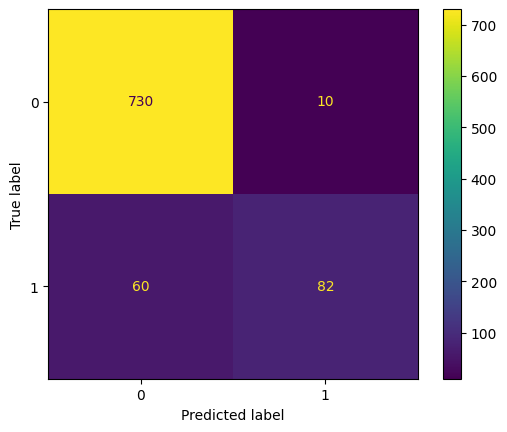

In [131]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=xgb_random_search.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_random_search.classes_)
disp.plot()
plt.show()

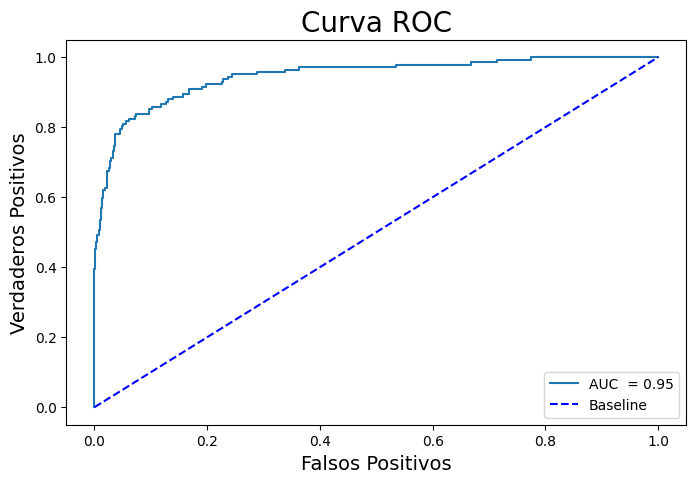

In [132]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = xgb_random_search.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

##Modelo final

In [169]:
# Modelo final Regresion Logistica
logreg_final_model = logreg_clf.fit(X, y)

In [173]:
# Modelo final
y_encoded = le.transform(y)

xgb_final_model = xgb_best_model.fit(X, y_encoded)